### Optimization of 2-D Himmelblaue function for varied coefficients
##### Reference: https://en.wikipedia.org/wiki/Himmelblau%27s_function
$$ cost(a,b,x,y) =  (x^2+y-a)^2 + (x+y^2-b)^2 ,$$
$$pdf(a,b,x,y) = e^{-cost(a,b,x,y)}$$ 

Here, $\mathbf{x}_{task}=(a,b)$ and $\mathbf{x}_{decision} = (x,y)$

Depending on the choice of task-parameters $(a,b)$ there could be several global optima.

We show that TTGO is able to find the multiple global optima consistently with a hand few of samples from the constructed tt-model of the above pdf (constructed offline) for various selection of $\mathbf{x}_{task}=(a,b)$ in the online phase.  We use scipy's SLSQP to fine tune the initialization. 

Condition on different values of $\mathbf{x}_{task}=(a,b)$ to test the model. Watch out for the multimodality in the solutions of TTGO!

Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
import torch
import numpy as np
import sys
sys.path.append('./fcn_opt')
sys.path.append('../')

from ttgo import TTGO
from test_fcns import Himmelblaue_4D 
from fcn_plotting_utils import plot_surf, plot_contour

%load_ext autoreload
np.set_printoptions(precision=3)
%autoreload 2

### Define the function

In [2]:
pdf, cost =  Himmelblaue_4D(alpha=1)

### Define the domain and the discretization

In [3]:
# Define the domain of the function
L = 5 # [-L,L]^2 is the domain of the function
# domain of task params: domain of coefficients a and b in Himmelblaue 
domain_task = [torch.linspace(1,15,500)]+[torch.linspace(1,15,500)] 
# domain of decision variables
domain_decision = [torch.linspace(-L,L,500)]*2 # domain of x-y coordinates 
domain = domain_task+domain_decision

### Fit the TT-Model

In [4]:
ttgo = TTGO(domain=domain,pdf=pdf,cost=cost)

In [5]:
ttgo.cross_approximate(rmax=100, nswp=20, kickrank=3)

cross device is cpu
Cross-approximation over a 4D domain containing 6.25e+10 grid points:
Note: The algorithm converges as the ratio tt-new-norm/tt-old-norm settles to 1. For TTGO, the convergence is not important, just keep iterating as long as the ratio > 1
iter: 0  | tt-new-norm/tt-old-norm: 1.753e-03 | time:   0.0103 | largest rank:   1
iter: 1  | tt-new-norm/tt-old-norm: 3.419e+00 | time:   0.0265 | largest rank:   4
iter: 2  | tt-new-norm/tt-old-norm: 1.217e+00 | time:   0.0495 | largest rank:   7
iter: 3  | tt-new-norm/tt-old-norm: 1.360e+00 | time:   0.0709 | largest rank:  10
iter: 4  | tt-new-norm/tt-old-norm: 1.292e+00 | time:   0.0993 | largest rank:  13
iter: 5  | tt-new-norm/tt-old-norm: 1.213e+00 | time:   0.1384 | largest rank:  16
iter: 6  | tt-new-norm/tt-old-norm: 1.177e+00 | time:   0.2078 | largest rank:  19
iter: 7  | tt-new-norm/tt-old-norm: 1.127e+00 | time:   0.2839 | largest rank:  22
iter: 8  | tt-new-norm/tt-old-norm: 1.055e+00 | time:   0.3883 | largest ran

In [6]:
sites_task = torch.tensor([0,1]) # sites to be consitioned upon (task-params)
ttgo.set_sites(sites_task)
ttgo.round(eps=1e-9)
print("TT-Rank: ", ttgo.tt_model.ranks_tt)

TT-Rank:  tensor([ 1, 39, 58, 57,  1])


In [7]:
# torch.save([ttgo.tt_model,domain],'himmel4D.pickle')

In [8]:
import tntorch as tnt
tnt.__file__

'/home/suhan/anaconda3/lib/python3.8/site-packages/tntorch/__init__.py'

### Sample from TT-Model

In [9]:
a=14; b=2.
x_task = torch.tensor([a,b]).view(1,-1) #given task-parameters
n_samples_tt = 100
samples, samples_idx = ttgo.sample(n_samples=n_samples_tt, x_task=x_task.view(1,-1), alpha=0, norm=1) 

### Choose the best sample as an estimate for optima

In [10]:
best_estimate = ttgo.choose_best_sample(samples)
top_k_estimate = ttgo.choose_top_k_sample(samples,k=50) # for multiple solutions

##### Fine-tune the estimate using gradient-based optimization

In [11]:
ttgo_optimized, _ = ttgo.optimize(best_estimate)

ttgo_optimized_k = 1*top_k_estimate
for i, x in enumerate(ttgo_optimized_k):
    ttgo_optimized_k[i], _ = ttgo.optimize(x)


In [12]:
print("PDF at the estimated point: ", pdf(best_estimate))
print("PDF at the optima: ", pdf(ttgo_optimized))

PDF at the estimated point:  tensor([0.9967])
PDF at the optima:  tensor([1.0000])


In [13]:
print("Estimated Optima: ", best_estimate)
print("Optima: ", ttgo_optimized)

Estimated Optima:  tensor([[13.9900,  2.0100, -4.0581, -2.4749]])
Optima:  tensor([[13.9900,  2.0100, -4.0560, -2.4627]])


### Visualization

In [14]:
# Redefinig the function given the coefficients
def cost_fcn(X):
    X = torch.from_numpy(X)
    X_ext = torch.empty(X.shape[0],4)
    X_ext[:,:2] = x_task
    X_ext[:,2:] = X
    return cost(X_ext).numpy()

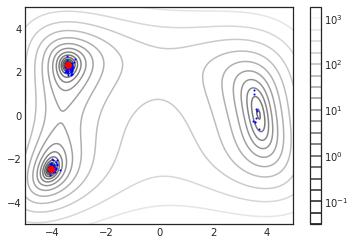

In [15]:
x = np.linspace(-L,L,200)
y = np.linspace(-L,L,200)
data = samples[:,2:]

plt=plot_contour(x,y,cost_fcn,data=data, contour_scale=1000, figsize=10, markersize=1)
# plt.plot(ttgo_optimized[:,2],ttgo_optimized[:,3],'*r',markersize=10)
plt.plot(ttgo_optimized_k[:,2],ttgo_optimized_k[:,3],'.r',markersize=10)
# plt.legend(["samples","optima"])
# plt.title(r"Himmelblau: $cost=(x^2+y-{})^2+(x+y^2-{})^2$".format(a,b))
# plt.savefig('Himmelblau4D_a13_b5_alpha0_ns1000_k10.png',pad_inches=0.01, dpi=300)
# plt.plot(gott_top_k_estimate[:,2],gott_top_k_estimate[:,3],'*r',markersize=8)

In [16]:
# plt = plot_surf(x,y,cost_fcn,data=data,zlim=(0,2000),figsize=10, view_angle=(45,45),markersize=3)

In [17]:
import tntorch
tntorch.__file__

'/home/suhan/anaconda3/lib/python3.8/site-packages/tntorch/__init__.py'